# Getting Started

`osier` is the first multi- and many-objective energy system optimization platform. This notebook offers a quick start guide to using its functionality.

In [72]:
# basic imports
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from unyt import kW, minute, hour, day, MW, GW, km
import sys
import time

# osier imports
from osier import CapacityExpansion
from osier.tech_library import nuclear_adv, solar, wind, battery
from osier import total_cost, annual_emission

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP

# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'glpk'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cbc


## Preparing input data

Users only need to supply relevant timeseries data to `osier`.

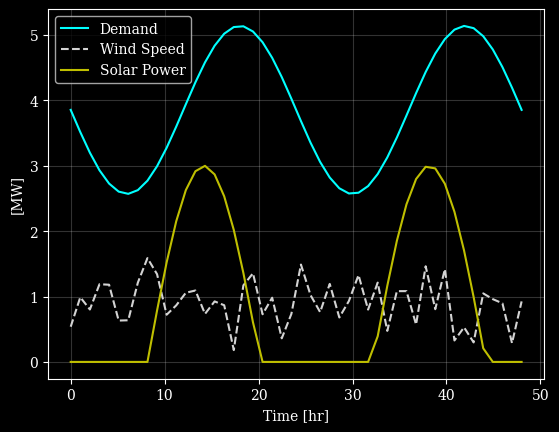

In [79]:
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 185  # [MWh], sets the total demand [units of energy]

np.random.seed(1234) # sets the seed for repeatability

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))
demand = demand/demand.sum() * total_demand  # rescale

shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

peak = 3
phase_shift = 1
solar_power = peak*(np.sin((hours*np.pi/n_hours*2+phase_shift))*-1)
solar_power[solar_power<0] = 0


with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan', label='Demand')
    plt.plot(hours, wind_speed, color='lightgray', linestyle='--', label='Wind Speed')
    plt.plot(hours, solar_power, color='y', label='Solar Power')
    plt.ylabel('[MW]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

## Set up the problem

In [42]:
problem = CapacityExpansion(technology_list = [solar, wind, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            solar=solar_power,
                            upper_bound= 1 / solar.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            solver=solver)

In [30]:
algorithm = NSGA2(pop_size=20)

start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      2 |             - |             -
     2 |       40 |      3 |  0.1194103225 |         ideal
     3 |       60 |      2 |  0.0915605619 |         ideal
     4 |       80 |      6 |  0.3090348032 |         ideal
     5 |      100 |      5 |  0.0599733939 |             f
     6 |      120 |      7 |  0.0296836436 |         ideal
     7 |      140 |      9 |  0.0952740970 |         ideal
     8 |      160 |      5 |  0.0031613166 |         ideal
     9 |      180 |      2 |  0.0251587904 |         ideal
    10 |      200 |      6 |  0.0156139632 |         ideal
The simulation took 3.668 minutes.


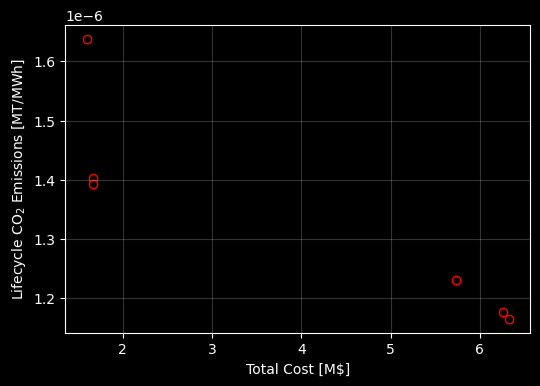

In [31]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()

/var/folders/6h/g412p7x53jbcqr_x5sy9z8th0000gn/T/ipykernel_64638/1527621391.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res.X,


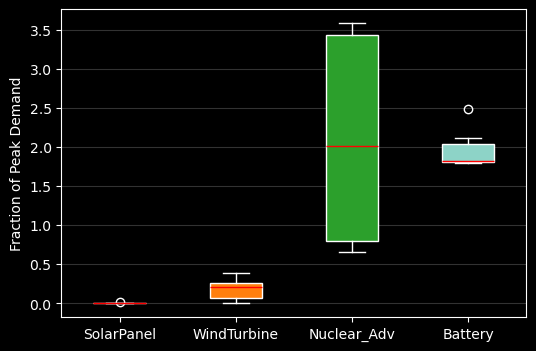

In [32]:
from osier import get_tech_names
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()

## Create new objectives

Users can create new objectives for any quantifiable metric. Here we add a parameter called `land_use` to the modeled technologies.

In [43]:
nuclear_adv.land_use = 4.4*1e-3 * (km**2/GW)
solar.land_use = 4.4e3*1e-3 * (km**2/GW)
wind.land_use = 12.3e3*1e-3 * (km**2/GW)
battery.land_use = 6.0*1e-3 * (km**2/GW)

Then, we create a function that calculates the total land use. The minimum required format is

```py
def objective(technology_list, solved_dispatch_model):
    # some calculation
    return objective
```

In [44]:
def land_use(technology_list, solved_dispatch_model):
    """
    Calculates land use intensity.
    """
    
    obj_value = np.array([t.capacity.to_value() * t.land_use for t in technology_list]).sum()
    
    return obj_value

Now, we re-initialize the problem with our new objective and updated technologies.

In [52]:
problem = CapacityExpansion(technology_list = [solar, wind, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            solar=solar_power,
                            upper_bound= 1 / solar.capacity_credit,
                            objectives = [total_cost, annual_emission, land_use],
                            solver=solver)

In [54]:
algorithm = NSGA2(pop_size=20)

start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      2 |             - |             -
     2 |       40 |      6 |  0.1722212257 |         ideal
     3 |       60 |      4 |  0.0847202466 |         ideal
     4 |       80 |      9 |  0.0500488235 |         ideal
     5 |      100 |      7 |  0.1077338796 |         ideal
     6 |      120 |      4 |  0.1315358768 |         ideal
     7 |      140 |      3 |  0.0298538369 |             f
     8 |      160 |      6 |  0.0177004796 |         ideal
     9 |      180 |     11 |  0.0939052676 |         ideal
    10 |      200 |     11 |  0.1230460927 |         ideal
The simulation took 3.954 minutes.


## Visualization


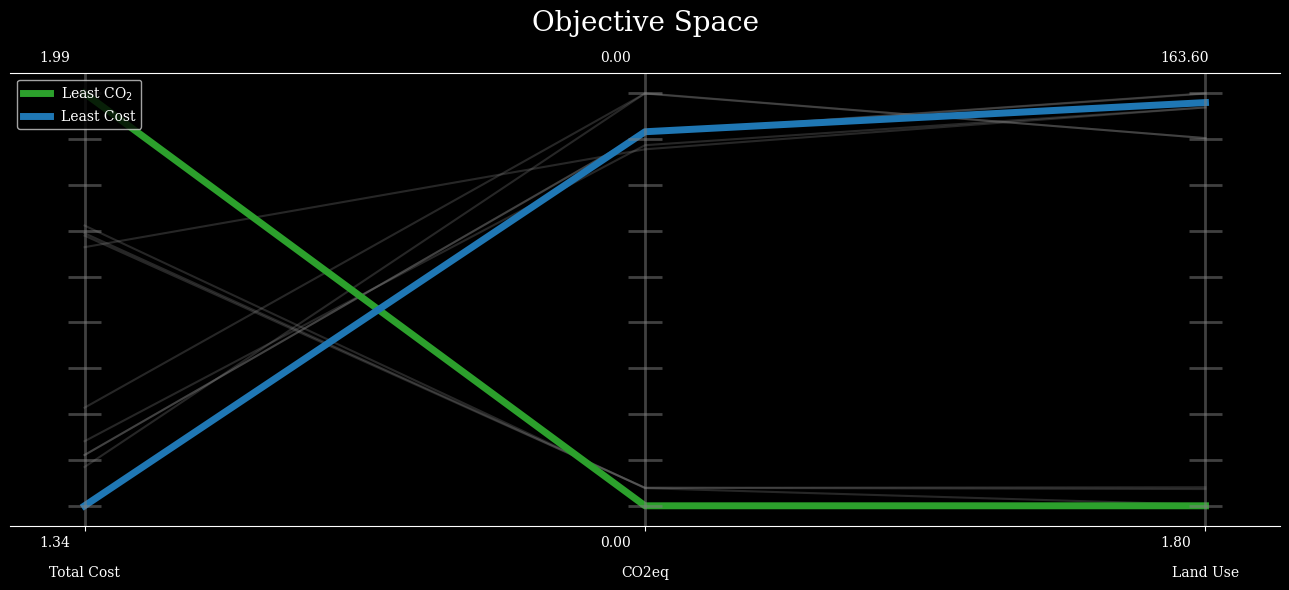

In [76]:
obj_labels=['Total Cost', 'CO2eq', 'Land Use']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

/var/folders/6h/g412p7x53jbcqr_x5sy9z8th0000gn/T/ipykernel_64638/3044223643.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res.X,


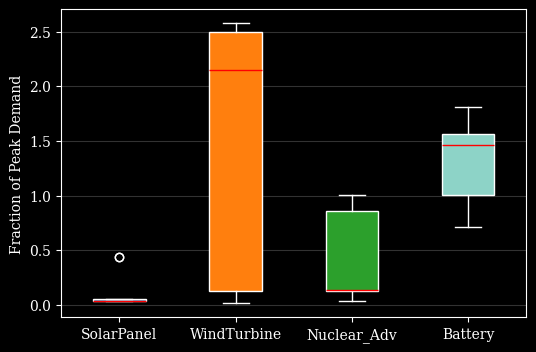

In [69]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()